# Assignment 2

In this assigment, we will work with the *Adult* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/2/adult). Extract the data files into the subdirectory: `../05_src/data/adult/` (relative to `./05_src/`).

# Load the data

Assuming that the files `adult.data` and `adult.test` are in `../05_src/data/adult/`, then you can use the code below to load them.

In [54]:
import pandas as pd
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week',
    'native-country', 'income'
]
adult_dt = (pd.read_csv('../../05_src/data/adult/adult.data', header = None, names = columns)
              .assign(income = lambda x: (x.income.str.strip() == '>50K')*1))


In [55]:
adult_dt.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [ ]:
#I want to be sure there the categories are correct
unique_categories_relationship = adult_dt['occupation'].unique()
print(unique_categories_relationship)

[' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']


There is a ' ?' category which I need to repace it with NA values.

In [ ]:
#I want to be sure there the categories are correct
unique_categories_relationship = adult_dt['education'].unique()
print(unique_categories_relationship)

[' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']


In [91]:
#I will replace this question mark with nan values.
import numpy as np
adult_dt['occupation'].replace(' ?', np.nan, inplace=True)

In [92]:
missing_values = adult_dt.isna()
missing_values.sum()

age                  0
workclass            0
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country       0
income               0
dtype: int64

# Get X and Y

Create the features data frame and target data:

+ Create a dataframe `X` that holds the features (all columns that are not `income`).
+ Create a dataframe `Y` that holds the target data (`income`).
+ From `X` and `Y`, obtain the training and testing data sets:

    - Use a train-test split of 70-30%. 
    - Set the random state of the splitting function to 42.

In [81]:
# Create the features dataframe X and target dataframe Y
X=adult_dt.drop(columns=['income'])
Y=adult_dt['income']

In [82]:
#Check for the columns
X.info()
Y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB
<class 'pandas.core.series.Series'>
RangeIndex: 32561 entries, 0 to 32560
Series name: income
Non-Null Count  Dtype
--------------  -----

In [83]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Display the shapes of the resulting datasets
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((22792, 14), (9769, 14), (22792,), (9769,))

In [84]:
# Display the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (22792, 14)
X_test shape: (9769, 14)
Y_train shape: (22792,)
Y_test shape: (9769,)


## Random States

Please comment: 

+ What is the [random state](https://scikit-learn.org/stable/glossary.html#term-random_state) of the [splitting function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)? 
+ Why is it [useful](https://en.wikipedia.org/wiki/Reproducibility)?

*(Comment here.)*

The **`random_state`** parameter in the splitting function is used to ensure reproducibility in the results. By setting a **random_state** value, we create a fixed sequence for randomly selecting data points for each run. This means that every time we rerun the code with the same **random_state**, we get the same training and testing split, which is crucial for consistency and debugging. In production, this consistency helps maintain predictable, stable outcomes across runs.

# Preprocessing

Create a [Column Transformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) that treats the features as follows:

- Numerical variables

    * Apply [KNN-based imputation for completing missing values](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html):
        
        + Consider the 7 nearest neighbours.
        + Weight each neighbour by the inverse of its distance, causing closer neigbours to have more influence than more distant ones.
    * [Scale features using statistics that are robust to outliers](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler).

- Categorical variables: 
    
    * Apply a [simple imputation strategy](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer):

        + Use the most frequent value to complete missing values, also called the *mode*.

    * Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html):
        
        + Handle unknown labels if they exist.
        + Drop one column for binary variables.
    
    
The column transformer should look like this:

![](./images/assignment_2__column_transformer.png)

In [85]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder

# Define numerical and categorical features
numerical_features = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
categorical_features = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]

# Define transformations for numerical and categorical features
numerical_transformer = Pipeline([
    ("KNNimputer", KNNImputer(n_neighbors=7, weights="distance")),  # KNN imputation
    ("Robustscaler", RobustScaler())  # Robust scaling
])

categorical_transformer = Pipeline([
    ("Simpleimputer", SimpleImputer(strategy="most_frequent")),  # Mode imputation for categorical
    ("OnehotEncoder", OneHotEncoder(handle_unknown="infrequent_if_exist", drop="if_binary"))  # One-hot encoding with drop for binary
])

# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num_transforms", numerical_transformer, numerical_features),
        ("cat_transforms", categorical_transformer, categorical_features)
    ]
)

preprocessor


ColumnTransformer(transformers=[('num_transforms',
                                 Pipeline(steps=[('KNNimputer',
                                                  KNNImputer(n_neighbors=7,
                                                             weights='distance')),
                                                 ('Robustscaler',
                                                  RobustScaler())]),
                                 ['age', 'fnlwgt', 'education-num',
                                  'capital-gain', 'capital-loss',
                                  'hours-per-week']),
                                ('cat_transforms',
                                 Pipeline(steps=[('Simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('OnehotEncoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='infrequent_if_exist'))]),
                                 ['workclass', 'education', 'marital-status',
                                  'occupation', 'relationship', 'race', 'sex',
                                  'native-country'])])

In case if you can't see the pipeline image 
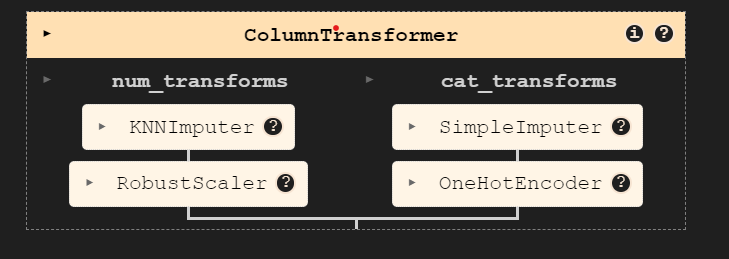

## Model Pipeline

Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `classifier` and assign a [`RandomForestClassifier()`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to it.

The pipeline looks like this:

![](./images/assignment_2__pipeline.png)

In [86]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Create the model pipeline with the ColumnTransformer and RandomForestClassifier
model_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),  # Use the ColumnTransformer created earlier
    ("RandomForestClassifier", RandomForestClassifier())  # RandomForestClassifier as the classifier step
])

model_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_transforms',
                                                  Pipeline(steps=[('KNNimputer',
                                                                   KNNImputer(n_neighbors=7,
                                                                              weights='distance')),
                                                                  ('Robustscaler',
                                                                   RobustScaler())]),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('cat_transforms',
                                                  Pipeline(steps=[('Simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('OnehotEncoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='infrequent_if_exist'))]),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('RandomForestClassifier', RandomForestClassifier())])

In case you can't see the pipeline
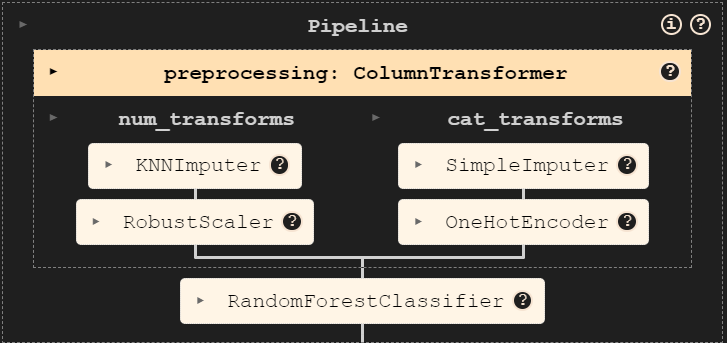

# Cross-Validation

Evaluate the model pipeline using [`cross_validate()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html):

+ Measure the following [preformance metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values): negative log loss, ROC AUC, accuracy, and balanced accuracy.
+ Report the training and validation results. 
+ Use five folds.


In [89]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, log_loss, roc_auc_score, accuracy_score, balanced_accuracy_score

# Define the scoring metrics
scoring = {
    'neg_log_loss': 'neg_log_loss',
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy',
    'balanced_accuracy': 'balanced_accuracy'
}

# Perform cross-validation with 5 folds
cv_results = cross_validate(
    model_pipeline, 
    X_train,  # Replace with your features dataframe
    Y_train,  # Replace with your target dataframe
    cv=5,
    scoring=scoring,
    return_train_score=True
)

# Display the cross-validation results

cv_results_df = pd.DataFrame(cv_results)
print(cv_results_df)



    fit_time  score_time  test_neg_log_loss  train_neg_log_loss  test_roc_auc  \
0  20.431726    0.385886          -0.349782           -0.081332      0.904640   
1  20.396338    0.357066          -0.347678           -0.081052      0.902212   
2  19.461164    0.385896          -0.382487           -0.081285      0.901151   
3  12.858827    0.170400          -0.379384           -0.082091      0.905379   
4   8.472082    0.169667          -0.393899           -0.081623      0.902410   

   train_roc_auc  test_accuracy  train_accuracy  test_balanced_accuracy  \
0            1.0       0.849309        0.999945                0.772694   
1            1.0       0.846896        1.000000                0.769257   
2            1.0       0.851689        1.000000                0.771962   
3            1.0       0.861343        1.000000                0.782641   
4            1.0       0.855638        0.999945                0.774569   

   train_balanced_accuracy  
0                 0.999887  
1   

Display the fold-level results as a pandas data frame and sorted by negative log loss of the test (validation) set.

In [93]:
# Convert cross-validation results to a DataFrame
cv_results_df = pd.DataFrame(cv_results)

# Sort the DataFrame by 'test_neg_log_loss' in ascending order (smaller log loss is better)
cv_results_df_sorted = cv_results_df.sort_values(by='test_neg_log_loss', ascending=True)

# Display the sorted DataFrame
print(cv_results_df_sorted)


    fit_time  score_time  test_neg_log_loss  train_neg_log_loss  test_roc_auc  \
4   8.472082    0.169667          -0.393899           -0.081623      0.902410   
2  19.461164    0.385896          -0.382487           -0.081285      0.901151   
3  12.858827    0.170400          -0.379384           -0.082091      0.905379   
0  20.431726    0.385886          -0.349782           -0.081332      0.904640   
1  20.396338    0.357066          -0.347678           -0.081052      0.902212   

   train_roc_auc  test_accuracy  train_accuracy  test_balanced_accuracy  \
4            1.0       0.855638        0.999945                0.774569   
2            1.0       0.851689        1.000000                0.771962   
3            1.0       0.861343        1.000000                0.782641   
0            1.0       0.849309        0.999945                0.772694   
1            1.0       0.846896        1.000000                0.769257   

   train_balanced_accuracy  
4                 0.999887  
2   

Calculate the mean of each metric. 

In [94]:
# Calculate the mean of each metric from the cross-validation results
cv_results_means = cv_results_df.mean()

# Display the mean values of each metric
cv_results_means


fit_time                   16.324027
score_time                  0.293783
test_neg_log_loss          -0.370646
train_neg_log_loss         -0.081477
test_roc_auc                0.903158
train_roc_auc               1.000000
test_accuracy               0.852975
train_accuracy              0.999978
test_balanced_accuracy      0.774225
train_balanced_accuracy     0.999955
dtype: float64

Calculate the same performance metrics (negative log loss, ROC AUC, accuracy, and balanced accuracy) using the testing data `X_test` and `Y_test`. Display results as a dictionary.

*Tip*: both, `roc_auc()` and `neg_log_loss()` will require prediction scores from `pipe.predict_proba()`. However, for `roc_auc()` you should only pass the last column `Y_pred_proba[:, 1]`. Use `Y_pred_proba` with `neg_log_loss()`.

In [95]:
# Fit the pipeline to the training data
model_pipeline.fit(X_train, Y_train)

# Generate predictions and prediction probabilities for X_test
Y_pred = model_pipeline.predict(X_test)
Y_pred_proba = model_pipeline.predict_proba(X_test)

# Calculate each performance metric
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score, balanced_accuracy_score

test_metrics = {
    'neg_log_loss': -log_loss(Y_test, Y_pred_proba),  # Negative log loss
    'roc_auc': roc_auc_score(Y_test, Y_pred_proba[:, 1]),  # ROC AUC score for the positive class
    'accuracy': accuracy_score(Y_test, Y_pred),  # Accuracy score
    'balanced_accuracy': balanced_accuracy_score(Y_test, Y_pred)  # Balanced accuracy score
}

# Display the test metrics
print(test_metrics)

{'neg_log_loss': -0.3964286888860209, 'roc_auc': np.float64(0.9002314955709481), 'accuracy': 0.8548469648889344, 'balanced_accuracy': np.float64(0.7760050072836906)}


# Target Recoding

In the first code chunk of this document, we loaded the data and immediately recoded the target variable `income`. Why is this [convenient](https://scikit-learn.org/stable/modules/model_evaluation.html#binary-case)?

The specific line was:

```
adult_dt = (pd.read_csv('../05_src/data/adult/adult.data', header = None, names = columns)
              .assign(income = lambda x: (x.income.str.strip() == '>50K')*1))
```

(Answer here.)

Recoding the target variable income to binary at the data-loading stage is convenient for using scikit-learn’s models and metrics, which often expect binary formats for classification. Converting >50K to 1 and <=50K to 0 ensures compatibility with accuracy, AUC-ROC, and log loss metrics, prevents errors from inconsistent formats, and simplifies metric calculation without extra transformations. It also improves interpretation, making it clear that a probability close to 1 indicates a higher likelihood of income >50K. This upfront recoding optimizes the data for efficient training, testing, and evaluation in machine learning workflows.

## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Becker,Barry and Kohavi,Ronny. (1996). Adult. UCI Machine Learning Repository. https://doi.org/10.24432/C5XW20.